In [331]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp

In [332]:
def sir_ode(times,init,parms):
    beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1 = parms
    S,E,P,I0,I1,R0,R1 = init
    # ODEs
    I = I0 + I1
    if I > 0:
        CFR = CFR1 - min(1, n_icu / (N*I*p_icu))*(CFR1 - CFR0)
    else:
        CFR = CFR0
    dS = -beta*S*(epsilon0*P + I0 + epsilon1*I1)
    dE = beta*S*(epsilon0*P + I0 + epsilon1*I1) - alpha*E
    dP = alpha*E - delta*P
    dI0 = delta*P - (gamma + c)*I0
    dI1 = c*I0 - gamma*I1
    dR0 = gamma*(1-CFR)*I0
    dR1 = gamma*(1-CFR)*I1
    return [dS,dE,dP,dI0,dI1,dR0,dR1]

In [333]:
N = 8000000
reproduction_num = 2.5
alpha = 0.25
epsilon0 = 0.15
epsilon1 = 1
delta = 1
gamma = 0.1
c = 0.1
CFR0 = 0.01
CFR1 = 0.02
p_icu = 0.0125
n_icu = 300 # beds


beta = reproduction_num/(epsilon0/delta + 1/gamma)

parms = [beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1]
S = 1 - 20/N
E = 20/N
P = 0
I0 = 0
I1 = 0
R0 = 0
R1 = 0
init = [S,E,P,I0,I1,R0,R1]
times = np.linspace(0,300,2000)

In [334]:
sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), t_span=[min(times),max(times)], y0=init, t_eval=times, rtol=1e-8)

In [335]:
sir_sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 590
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.50075038e-01, 3.00150075e-01, ...,
       2.99699850e+02, 2.99849925e+02, 3.00000000e+02])
 t_events: None
        y: array([[9.99997500e-01, 9.99997500e-01, 9.99997498e-01, ...,
        1.07432846e-01, 1.07432122e-01, 1.07431402e-01],
       [2.50000000e-06, 2.40826672e-06, 2.32078639e-06, ...,
        2.58220201e-05, 2.55805803e-05, 2.53442213e-05],
       [0.00000000e+00, 8.54562157e-08, 1.55873850e-07, ...,
        6.19467961e-06, 6.10008263e-06, 6.08807415e-06],
       ...,
       [0.00000000e+00, 3.44957522e-11, 2.52017918e-10, ...,
        1.32207906e-04, 1.30974604e-04, 1.29764332e-04],
       [0.00000000e+00, 3.41604220e-11, 2.51317119e-10, ...,
        4.37571884e-01, 4.37572620e-01, 4.37573360e-01],
       [0.00000000e+00, 9.62729571e-15, 1.81938024e-12, ...,
        4.37476

In [336]:
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"E":sir_sol["y"][1],"P":sir_sol["y"][2],"I0":sir_sol["y"][3],"I1":sir_sol["y"][4],"R0":sir_sol["y"][5],"R1":sir_sol["y"][6]})

In [337]:
sir_out["D"] = 1 - sir_out["S"] - sir_out["E"] - sir_out["P"] - sir_out["I0"] - sir_out["I1"] - sir_out["R0"] - sir_out["R1"]

In [338]:
sir_out = sir_out * N
sir_out['t'] = sir_out['t']/N

#### Visualisation

In [339]:
import matplotlib.pyplot as plt

In [340]:
plt.style.use("ggplot")

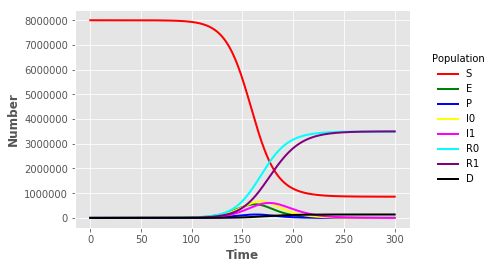

In [341]:
sline = plt.plot("t","S","",data=sir_out,color="red",linewidth=2)
iline = plt.plot("t","E","",data=sir_out,color="green",linewidth=2)
rline = plt.plot("t","P","",data=sir_out,color="blue",linewidth=2)
rline = plt.plot("t","I0","",data=sir_out,color="yellow",linewidth=2)
rline = plt.plot("t","I1","",data=sir_out,color="magenta",linewidth=2)
rline = plt.plot("t","R0","",data=sir_out,color="cyan",linewidth=2)
rline = plt.plot("t","R1","",data=sir_out,color="purple",linewidth=2)
rline = plt.plot("t","D","",data=sir_out,color="black",linewidth=2)
plt.xlabel("Time",fontweight="bold")
plt.ylabel("Number",fontweight="bold")
legend = plt.legend(title="Population",loc=5,bbox_to_anchor=(1.25,0.5))
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_linewidth(0)

In [342]:
sir_out["total"] = sir_out["S"] + sir_out["E"] + sir_out["P"] + sir_out["I0"] + sir_out["I1"] + sir_out["R0"] + sir_out["R1"]

In [343]:
sir_out

,t,S,E,P,I0,I1,R0,R1,D,total
0,0.000000,7.999980e+06,20.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.310224e-10,8.000000e+06
1,0.150075,7.999980e+06,19.266134,0.683650,0.052297,0.000276,2.732834e-04,7.701837e-08,2.761282e-06,8.000000e+06
2,0.300150,7.999980e+06,18.566291,1.246991,0.195051,0.002016,2.010537e-03,1.455504e-05,2.045599e-05,8.000000e+06
3,0.450225,7.999980e+06,17.901617,1.708011,0.409150,0.006401,6.411419e-03,7.422163e-05,6.551131e-05,8.000000e+06
4,0.600300,7.999980e+06,17.323448,2.223508,0.484820,0.036751,3.444662e-02,-1.936820e-03,3.283819e-04,8.000000e+06
...,...,...,...,...,...,...,...,...,...,...
1995,299.399700,8.594745e+05,210.537790,52.361002,412.626472,1077.854044,3.500563e+06,3.499777e+06,1.384318e+05,7.861568e+06
1996,299.549775,8.594686e+05,208.542338,50.797570,410.147997,1067.689596,3.500569e+06,3.499793e+06,1.384320e+05,7.861568e+06
1997,299.699850,8.594628e+05,206.576160,49.557437,407.302427,1057.663247,3.500575e+06,3.499809e+06,1.384322e+05,7.861568e+06
1998,299.849925,8.594570e+05,204.644643,48.800661,403.887111,1047.796835,3.500581e+06,3.499825e+06,1.384324e+05,7.861568e+06
